# Reanalysis preprocessing
***

__Author__: Chus Casado<br>
__Date__:   09-01-2022<br>

__Introduction__:<br>
This code extracts from the EFAS reanalysis data the discharge series in a selection of fixed reporting points.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

path_root = os.getcwd()

## Configuration

In [2]:
path_data = '../data/'

path_reanalysis = '../data/CDS/reanalysis/'

# area threshold
area_threshold = 500

## Stations

Load the table with all EFAS fixed reporting point and filter those points for which discharge data will be extracted.

In [3]:
os.chdir(path_root)
os.chdir(path_data)

# load table of fixed reporing points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')

# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area_threshold) & (stations.FixedRepPoint == True)
stations_sel = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'Catchment', 'River', 'EC_Catchments', 'Country code']]

print(f'No. stations:\t{stations_sel.shape[0]}')

No. stations:	2371


## Discharge data

In [4]:
os.chdir(path_root)
os.chdir(path_reanalysis)

# netCDF with EFAS reanalysis
files = glob.glob(f'*.nc')

The following cell has the problem that if fills up the memory, so at some point it slows down dramatically

In [6]:
# xarrys with station coordinates that will be used to extract data
x = xr.DataArray(stations_sel.LisfloodX, dims='id')
y = xr.DataArray(stations_sel.LisfloodY, dims='id')

for file in files:
    year = file.split('_')[-1].split('.')[0]
    output_file = f'EFAS_reanalysis_{year}.csv'
    
    print(f'\n{year}')
    
    if output_file not in os.listdir():
        # load dataset and extract variable discharge
        ds = xr.open_dataset(file)
        dis = ds['dis06']
        ds.close()
        
        # extract discharge for the selected stations
        dis_sel = dis.sel(x=x, y=y, method='nearest')
        
        # create dataframe with the discharge data for each reporting point
        dis_df = pd.DataFrame(index=dis_sel.time, columns=dis_sel.id, dtype=float)
        dis_df.index.name = 'datetime'
        for i, id in enumerate(dis_df.columns):
            print(f'Point {i + 1:04d} out of {dis_df.shape[1]}', end='\r')
            dis_df[id] = dis_sel.sel(id=id).round(1)

        # export dataframe as CSV
        dis_df.to_csv(output_file, float_format='%.1f')
        del dis_df, dis_sel
    else:
        print(f'{output_file} already exists')


2018
EFAS_reanalysis_2018.csv already exists

2019
EFAS_reanalysis_2019.csv already exists

2020
EFAS_reanalysis_2020.csv already exists

2021
EFAS_reanalysis_2021.csv already exists

2022
Point 2371 out of 2371



NameError: name 'x' is not defined

Another posible way to extract the data will be the following, but it is also quite slow.

```Python
X = xr.DataArray(stations_sel.LisfloodX, dims='id')
Y = xr.DataArray(stations_sel.LisfloodY, dims='id')

data = dis.sel(x=X, y=Y)

data.to_dataframe()
```

## Load discharge series

We'll load one by one the discharge timeseries for each year and concatenate them.

In [16]:
dis = pd.DataFrame(dtype=float)
for file in glob.glob(f'*.csv'):
    df = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col=0)
    df.columns = [int(col) for col in df.columns]
    dis = pd.concat((dis, df), axis=0)

To visually check the time series, we will plot the data for the Ebro catchment.

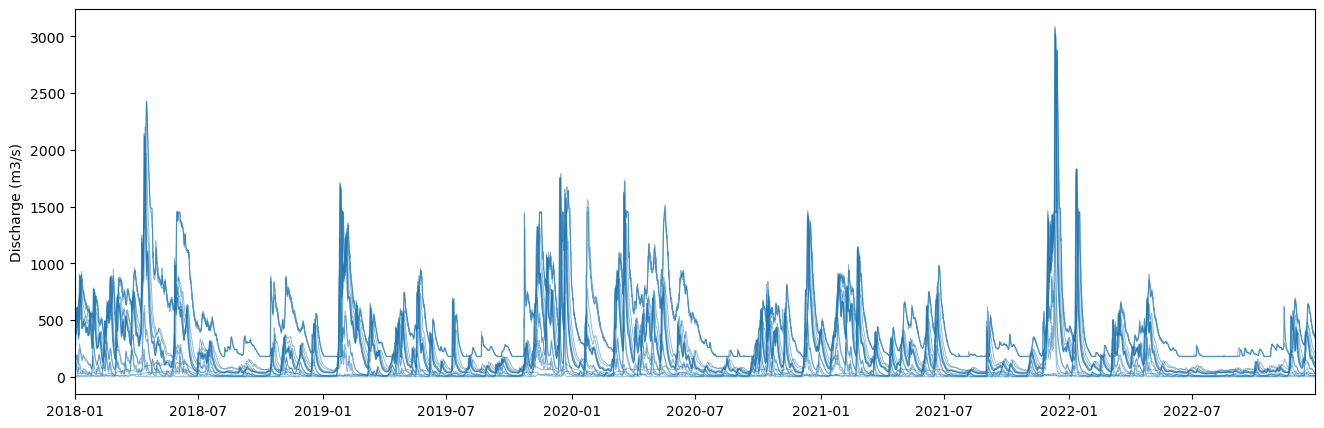

In [22]:
catchment = 'Ebro'

# filter stations in the catchment
stn_catchment = stations_sel.loc[stations_sel.River == catchment, :]

# plot discharge
plt.figure(figsize=(16, 5))
plt.plot(dis[stn_catchment.index.tolist()], lw=.7, c='C0', alpha=.5)
plt.xlim((dis.index[0], dis.index[-1]))
plt.ylabel('Discharge (m3/s)');